In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.8 MB/s eta 0:00:00


# Import Library and Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

# Data Preparation

Data is taken from: https://www.kaggle.com/datasets/rendiputra/stunting-balita-detection-121k-rows

## Gathering Data

In [3]:
data = pd.read_csv('data_balita.csv')
data.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


This table contains 4 columns. Below is an explanation of these 4 columns:

*   Umur (bulan):  The child's age in months
*   Jenis Kelamin : Male or female
*   Tinggi Badan (cm) : The child's height in centimeters.
*   Status Gizi :

      *    Normal
      *   Severely Stunted
      *   Stunted
      *   Tinggi




## Assessing Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


There are no inconsistencies in the data.

In [5]:
print("Jumlah duplikasi: ", data.duplicated().sum())
data.describe()

Jumlah duplikasi:  81574


,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


There are 81574 duplicated rows.


In [6]:
data.isna().sum()

,0
Umur (bulan),0
Jenis Kelamin,0
Tinggi Badan (cm),0
Status Gizi,0


There are no columns with missing values.

In [7]:
data.dtypes

,0
Umur (bulan),int64
Jenis Kelamin,object
Tinggi Badan (cm),float64
Status Gizi,object


To display the data type of each column:


*   Umur (bulan): Represented as an integer
*   Jenis Kelamin: Represented as a string or categorical
*   Tinggi Badan (cm): Represented as a floating-point number
*   Status Gizi: Represented as a string or categorical



In [8]:
data[data.duplicated(subset=['Jenis Kelamin', 'Umur (bulan)', 'Tinggi Badan (cm)','Status Gizi'])]

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
6012,3,laki-laki,62.1,normal
6014,3,laki-laki,59.2,normal
6027,3,laki-laki,61.4,normal
6031,3,laki-laki,71.0,tinggi
6032,3,laki-laki,51.5,severely stunted
...,...,...,...,...
120994,60,perempuan,100.6,normal
120995,60,perempuan,98.3,stunted
120996,60,perempuan,121.3,normal
120997,60,perempuan,112.2,normal


Display the duplicate rows based on the values in the columns of jenis kelamin, umur, tinggi badan, dan status gizi.

In [9]:
data[~data.duplicated(subset=['Jenis Kelamin', 'Umur (bulan)', 'Tinggi Badan (cm)', 'Status Gizi'])]

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted
...,...,...,...,...
120959,60,perempuan,100.700000,normal
120967,60,perempuan,113.700000,normal
120968,60,perempuan,107.500000,normal
120972,60,perempuan,127.600000,tinggi


Filter the unique rows, the non-duplicate rows based on the values in the columns of jenis kelamin, umur, tinggi badan, dan status gizi.

## Cleaning Data

In [10]:
data = data.drop_duplicates()
print(f"Banyaknya data setelah proses cleaning: {len(data)}")

Banyaknya data setelah proses cleaning: 39425


Delete the duplicate rows, which total 39425.


## Features Engineering

**Categorical Encoding:**

In [46]:
le = LabelEncoder()
data['Jenis Kelamin'] = le.fit_transform(data['Jenis Kelamin'])
print("Kategori Jenis Kelamin yang telah dienkode secara berurutan [0,1]: ", le.classes_)
data['Status Gizi'] = le.fit_transform(data['Status Gizi'])
print("Kategori Status Gizi yang telah dienkode secara berurutan [0,1,2,3]: ", le.classes_)
joblib.dump(le, 'label_encoder.pkl')

Kategori Jenis Kelamin yang telah dienkode secara berurutan [0,1]:  [0 1]
Kategori Status Gizi yang telah dienkode secara berurutan [0,1,2,3]:  [0 1 2 3]


['label_encoder.pkl']

To convert categorical columns into numeric values (integers)

In [40]:
data['Status Gizi'].value_counts().sort_index()

,count
Status Gizi,
0,21514
1,6520
2,4417
3,6974


Calculate the frequency of each category in the **Status Gizi** column, and then sort them by index (category).

It appears that the most common data status is "Normal," while the least common is "Stunted."

In [ ]:
data.to_csv('data_cleaned.csv', index=False)

Save the cleaned dataset.

In [13]:
x = data.drop(columns=['Status Gizi'])
y = data['Status Gizi']

x will store a DataFrame containing the features that will be used for prediction. This DataFrame will include all columns except for Status Gizi.

y will store the Status Gizi column, which is the target for the model.

**SMOTE:**

SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to perform oversampling on imbalanced datasets.

In [14]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

data_balanced = pd.concat([pd.DataFrame(x_resampled, columns=x.columns), pd.Series(y_resampled, name='Status Gizi')], axis=1)
print("Banyaknya isi setiap kelas setelah oversampling:")
print(data_balanced['Status Gizi'].value_counts())

Banyaknya isi setiap kelas setelah oversampling:
Status Gizi
2    21514
3    21514
0    21514
1    21514
Name: count, dtype: int64


Before applying SMOTE, the data in each category of the **Status Gizi** column was imbalanced. After performing SMOTE, the number of data points in each category is now equal.

In [41]:
data_balanced.to_csv('data_after_oversampling.csv', index=False)

Save after the oversampling dataset.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

The oversampled dataset will be split into training data (train) and testing data (test).

20% of the data will be used for **x_test** and **y_test**, while 80% will be used for **x_train** and **y_train** (selected randomly).

**NORMALIZATION and SCALING:**

In [42]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Perform standardization or normalization on the data to ensure that the features have the same scale.

In [17]:
print("Shape x_train:", x_train.shape)


Shape x_train: (68844, 3)


Display the dimensions of **x_train**, which refers to the number of rows and columns after the data splitting and standardization process.

#Model

## Building a Model Using TensorFlow




In [43]:
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

Apply a model to the data

**Compile Model:**

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Train the model using the fit() method:**

In [20]:
history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7281 - loss: 0.6300 - val_accuracy: 0.9263 - val_loss: 0.1865
Epoch 2/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8972 - loss: 0.2601 - val_accuracy: 0.9350 - val_loss: 0.1547
Epoch 3/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9184 - loss: 0.2043 - val_accuracy: 0.9542 - val_loss: 0.1191
Epoch 4/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9263 - loss: 0.1857 - val_accuracy: 0.9612 - val_loss: 0.1005
Epoch 5/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9329 - loss: 0.1693 - val_accuracy: 0.9728 - val_loss: 0.0864
Epoch 6/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9381 - loss: 0.1556 - val_accuracy: 0.9686 - val_loss: 0.0914
Epoch 7/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9402 - loss: 0.1501 - val_accuracy: 0.9637 - val_loss: 0.0834
Epoch 8/15
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9429 - loss: 0.1

After training, the model achieved an accuracy of 95% with a loss of 0.1.

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,980 (42.89 KB)

 Trainable params: 10,980 (42.89 KB)

 Non-trainable params: 0 (0.00 B)

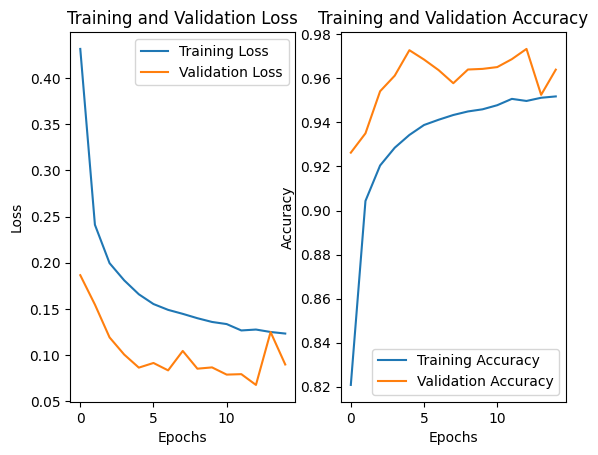

In [21]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Visualize the model's performance by displaying the loss and accuracy graphs for the training and validation data.

In [45]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Predicting target data with a trained model

**Evaluates model:**

In [23]:
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

                  precision    recall  f1-score   support

          normal       0.97      0.93      0.95      4310
severely stunted       0.99      0.97      0.98      4297
         stunted       0.95      0.98      0.97      4432
          tinggi       0.95      0.97      0.96      4173

        accuracy                           0.96     17212
       macro avg       0.96      0.96      0.96     17212
    weighted avg       0.96      0.96      0.96     17212



It appears that a classification performance report is generated, including:

* **Precision**: The proportion of positive predictions that are correct.
* **Recall**: The proportion of actual positive data correctly identified.
* **F1-Score**: The harmonic mean of precision and recall.
* **Support**: The number of samples for each class.

**Display the Confusion Matrix:**

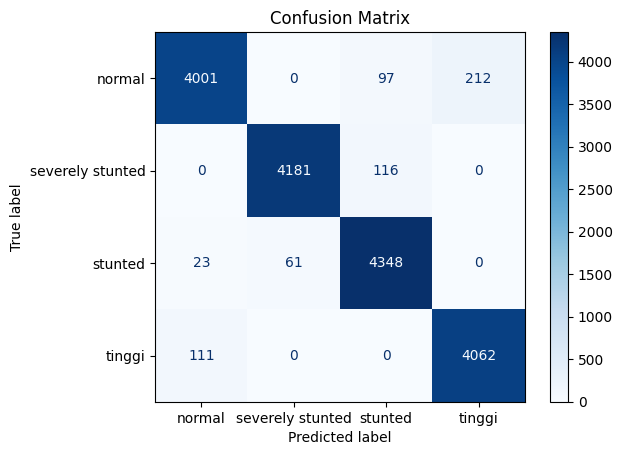

In [24]:
cm = confusion_matrix(y_test, y_pred_classes)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


Based on this confusion matrix, it shows the number of correct and incorrect predictions for each class.

## Hyperparameter Tuning

In [25]:
# Definisikan fungsi untuk membangun model dengan hyperparameter tuning
def build_model(hp):
    model = Sequential()
    # Pilih jumlah neuron pada layer pertama (64, 128, 256)
    model.add(Input(shape=(x_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_input', min_value=64, max_value=256, step=64),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.2, max_value=0.5, step=0.1)))

    # Tambahkan layer tersembunyi yang dapat di-tuning
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    # Lapisan output
    model.add(Dense(4, activation='softmax'))

    # Pilih learning rate dari optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Atur tuner untuk mencari parameter terbaik
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Jumlah kombinasi hyperparameter yang ingin dicoba
    executions_per_trial=2,  # Melakukan beberapa eksekusi per trial untuk hasil yang lebih konsisten
    directory='keras_tuner_dir',
    project_name='tuning_gizi_model'
)

# Jalankan tuner untuk mencari parameter terbaik
tuner.search(x_train, y_train, epochs=15, validation_data=(x_test, y_test))

# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluasi model terbaik
val_loss, val_accuracy = best_model.evaluate(x_test, y_test)
print(f"Best model validation accuracy: {val_accuracy}")

# Print hyperparameter terbaik
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Units per layer: {best_hyperparameters.get('units_input')}")
print(f"Learning rate: {best_hyperparameters.get('learning_rate')}")
for i in range(best_hyperparameters.get('num_layers')):
    print(f"Units in layer {i+1}: {best_hyperparameters.get(f'units_{i}')}")
    print(f"Dropout rate in layer {i+1}: {best_hyperparameters.get(f'dropout_{i}')}")

Trial 10 Complete [00h 04m 32s]
val_accuracy: 0.9754531681537628

Best val_accuracy So Far: 0.9775737822055817
Total elapsed time: 00h 43m 48s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9768 - loss: 0.0705
Best model validation accuracy: 0.9776899814605713
Best Hyperparameters:
Units per layer: 128
Learning rate: 0.0007558360818294099
Units in layer 1: 96
Dropout rate in layer 1: 0.2


The results obtained from this hyperparameter tuning process successfully improved the model's accuracy. The validation accuracy reached 97%, and the training accuracy reached 98%.

In [26]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 96)                  │          12,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,284 (51.89 KB)

 Trainable params: 13,284 (51.89 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


**Evaluates Best Model:**

In [28]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

Classification Report:
                  precision    recall  f1-score   support

          normal       0.98      0.96      0.97      4310
severely stunted       0.98      0.99      0.99      4297
         stunted       0.97      0.98      0.98      4432
          tinggi       0.98      0.98      0.98      4173

        accuracy                           0.98     17212
       macro avg       0.98      0.98      0.98     17212
    weighted avg       0.98      0.98      0.98     17212



It can be seen that the classification performance report has improved from before.

**Display the Confusion Matrix:**

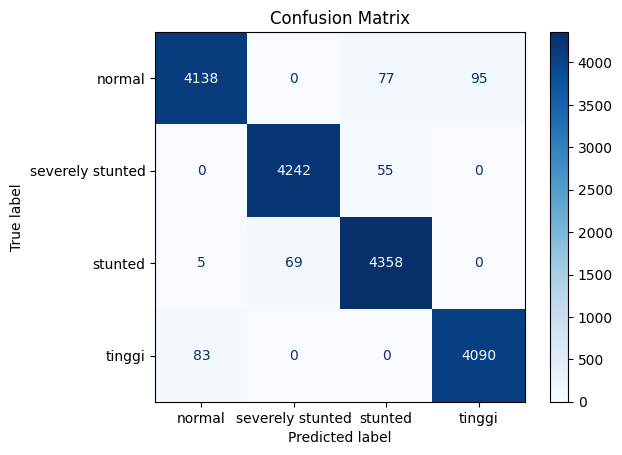

In [29]:
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

It can be seen that the number of correct predictions increases for each class increase.

#Save Model

In [30]:
model.save('model.h5')
best_model.save('best_model.h5')

In [31]:
model.save_weights('model.weights.h5')
best_model.save_weights('model.weights.h5')

In [32]:
model.save('model.keras')
best_model.save('best_model.keras')

## Convert Model to TFLite

In [33]:
model_converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = model_converter.convert()

with open('/content/model.tflite', 'wb') as f:
    f.write(model_tflite)

best_model_converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
best_model_tflite = best_model_converter.convert()

with open('/content/best_model.tflite', 'wb') as f:
    f.write(best_model_tflite)

print("Models saved as .tflite")


Saved artifact at '/tmp/tmpa4wwhkyr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137276325242736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137276323701408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137276323704400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137276323944000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137276323941536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137276323942240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137276323942944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137276323944528: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmpoicgqsez'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.floa

In [34]:
# Path ke model TFLite
tflite_model_path = '/content/best_model.tflite'

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Dapatkan informasi tentang input dan output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Periksa shape dan tipe input/output
print(f"Input details: {input_details}")
print(f"Output details: {output_details}")

# Contoh input data (ubah sesuai dengan data yang kamu punya)
input_data = np.array(np.random.random_sample(input_details[0]['shape']), dtype=np.float32)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inferensi
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output:", output_data)


Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [[9.9994802e-01 0.0000000e+00 1.6622493e-09 5.1965741e-05]]


In [36]:
from tensorflow.keras.models import load_model

savedModel=load_model('best_model.h5')
savedModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 96)                  │          12,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,286 (51.90 KB)

 Trainable params: 13,284 (51.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [37]:
a = load_model('model.h5')
b = load_model('best_model.h5')
val_loss, val_accuracy = a.evaluate(x_test, y_test)
print(f"Model Validation Accuracy: {val_accuracy}")

val_loss_best, val_accuracy_best = b.evaluate(x_test, y_test)
print(f"Best Model Validation Accuracy: {val_accuracy_best}")

538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9597 - loss: 0.0946
Model Validation Accuracy: 0.96397864818573
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9768 - loss: 0.0705
Best Model Validation Accuracy: 0.9776899814605713


# Prediction and Model Testing


Try loading the model and making predictions by inputting data such as age, height, and gender. Based on the prediction results, the script provides food recommendations that are suitable for the detected nutritional status.

In [38]:
# Memuat model yang telah dilatih
model = tf.keras.models.load_model('best_model.h5')


# Data input (contoh)
umur = 38
tinggi_badan = 109.8
jenis_kelamin = 0  # 0 untuk laki-laki, 1 untuk perempuan

# Proses input menjadi bentuk yang sesuai untuk model
data_input = np.array([umur, jenis_kelamin, tinggi_badan]).reshape(1, -1)
print((data_input))
data_input = scaler.transform(data_input)
print((data_input))

# Melakukan prediksi
y_pred = model.predict(data_input)
hasil_prediksi = np.argmax(y_pred, axis=1)
print((y_pred))

# Mengubah hasil prediksi menjadi nama kelas
class_names = le.inverse_transform(hasil_prediksi)
hasil_prediksi = class_names[0]


# Percabangan untuk rekomendasi berdasarkan hasil prediksi dan umur
if hasil_prediksi == 'normal':
    if umur <= 6:
        frekuensi_makan = "Sesuai kebutuhan bayi"
        rekomendasi_makanan = "ASI Eksklusif"
    elif 6 < umur < 12:
        frekuensi_makan = "2-3 kali MPASI, 1-2 Makanan Selingan + ASI"
        rekomendasi_makanan = {
            'Protein 30-45 gr': ['ikan', 'daging', 'ayam', 'telur 1/2 butir'],
            'Lemak 30 gr': ['minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 125 ml:': ['ubi', 'kentang', 'nasi'],
            'Sayur 100 gr': ['bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 50 gr:': ['pisang', 'jeruk', 'kiwi'],
            'Susu 250 ml': ['ASI', 'Susu Formula Pertumbuhan']
        }
    else:
        frekuensi_makan = "3 Makanan Utama, 1 Makanan Selingan"
        rekomendasi_makanan = {
            'Protein 26 gr': ['ikan', 'daging', 'ayam', 'telur 1 butir'],
            'Lemak 35-40 gr': ['minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 150 ml': ['ubi', 'kentang', 'nasi'],
            'Sayur 200 gr': ['bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 200 gr': ['pisang', 'jeruk', 'kiwi'],
            'Susu 250 ml' : ['Susu Formula Pertumbuhan', 'Susu Sapi UHT', 'Susu Kedelai']
        }

    print(f"Anak terdeteksi Normal. Berikut beberapa informasi yang bisa berguna:")
    print("Silakan cek artikel mengenai stunting di bawah ini untuk informasi lebih lanjut:")
    print("1. https://humbanghasundutankab.go.id/main/index.php/read/news/828")
    print("2. https://stunting.go.id/")
    print("3. https://berkas.dpr.go.id/pusaka/files/info_singkat/Info%20Singkat-XV-14-II-P3DI-Juli-2023-196.pdf")


elif hasil_prediksi == 'severely stunted':
    if umur <= 6:
        frekuensi_makan = "Sesuai kebutuhan bayi"
        rekomendasi_makanan = "ASI Eksklusif"
    elif 6 < umur < 12:
        frekuensi_makan = "3-4 kali MPASI, 1-2 Makanan Selingan + ASI"
        rekomendasi_makanan = {
            'Protein 45-60 gr': ['ikan', 'daging', 'ayam', 'telur 1 butir'],
            'Lemak 40 gr': ['minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 125 ml': ['ubi', 'kentang', 'nasi'],
            'Sayur 100 gr': ['bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 50-100 gr:': ['pisang', 'jeruk', 'kiwi'],
            'Susu 300-350 ml': ['ASI', 'Susu Formula Pertumbuhan']
        }
    else:
        frekuensi_makan = "3 Makanan Utama, 2 Makanan Selingan"
        rekomendasi_makanan = {
            'Protein 26-30 gr': ['ikan', 'daging', 'ayam', 'telur 1 butir'],
            'Lemak 40 gr': ['minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 150-160 ml': ['ubi', 'kentang', 'nasi'],
            'Sayur 200 gr': ['bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 200 gr': ['pisang', 'jeruk', 'kiwi'],
            'Susu 350 ml' : ['Susu Formula Pertumbuhan', 'Susu Sapi UHT', 'Susu Kedelai']
        }
    print("Anak terdeteksi Severely Stunting. Mohon segera periksakan anak ke ahli gizi atau puskesmas terdekat.")

elif hasil_prediksi == 'stunted':
    if umur <= 6:
        frekuensi_makan = "Sesuai kebutuhan bayi"
        rekomendasi_makanan = "ASI Eksklusif"
    elif 6 < umur < 12:
        frekuensi_makan = "3 kali MPASI, 1-2 Makanan Selingan + ASI"
        rekomendasi_makanan = {
            'Protein 45 gr': ['ikan', 'daging', 'ayam', 'telur 1/2 - 1 butir'],
            'Lemak 30-40 gr': [ 'minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 125 ml': ['ubi', 'kentang', 'nasi'],
            'Sayur 100 gr': [ 'bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 50 gr': ['pisang', 'jeruk', 'kiwi'],
            'Susu 250 ml': ['ASI', 'Susu Formula Pertumbuhan']
        }
    else:
        frekuensi_makan = "3 Makanan Utama, 1-2 Makanan Selingan"
        rekomendasi_makanan = {
            'Protein 20-26 gr': ['ikan', 'daging', 'ayam', 'telur 1 butir'],
            'Lemak 35-40 gr': ['minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 150 ml': ['ubi', 'kentang', 'nasi'],
            'Sayur 200 gr': [ 'bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 200 gr': [ 'pisang', 'jeruk', 'kiwi'],
            'Susu 250-300 ml': ['Susu Formula Pertumbuhan', 'Susu Sapi UHT', 'Susu Kedelai']
        }

    print("Anak terdeteksi Stunting. Mohon segera periksakan anak ke ahli gizi atau puskesmas terdekat.")

elif hasil_prediksi == 'tinggi':
    if umur <= 6:
        frekuensi_makan = "Sesuai kebutuhan bayi"
        rekomendasi_makanan = "ASI Eksklusif"
    elif 6 < umur < 12:
        frekuensi_makan = "3 kali MPASI, 1-2 Makanan Selingan + ASI"
        rekomendasi_makanan = {
            'Protein 60 gr': ['ikan', 'daging', 'ayam', 'telur 1/2 - 1 butir'],
            'Lemak 40-45 gr': ['minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 150 ml': ['ubi', 'kentang', 'nasi'],
            'Sayur 100 gr': ['bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 200 gr': ['pisang', 'jeruk', 'kiwi'],
            'Susu 300-350 ml': ['ASI', 'Susu Formula Pertumbuhan']
        }
    else:
        frekuensi_makan = "3 Makanan Utama, 2 Makanan Selingan"
        rekomendasi_makanan = {
            'Protein 30-35 gr': ['ikan', 'daging', 'ayam', 'telur 1 butir'],
            'Lemak 40-45 gr': ['minyak Sehat (minyak ikan atau minyak kedelai)'],
            'Karbohidrat 160-180 ml': ['ubi', 'kentang', 'nasi'],
            'Sayur 200 gr': ['bayam', 'labu kuning', 'brokoli', 'wortel'],
            'Buah 200 gr': ['pisang', 'jeruk', 'kiwi'],
            'Susu 350 ml' : ['Susu Formula Pertumbuhan', 'Susu Sapi UHT', 'Susu Kedelai']
        }

    print(f"Anak terdeteksi memiliki pertumbuhan yang Tinggi. Berikut beberapa informasi yang bisa berguna:")
    print("Silakan cek artikel mengenai stunting di bawah ini untuk informasi lebih lanjut:")
    print("1. https://humbanghasundutankab.go.id/main/index.php/read/news/828")
    print("2. https://stunting.go.id/")
    print("3. https://berkas.dpr.go.id/pusaka/files/info_singkat/Info%20Singkat-XV-14-II-P3DI-Juli-2023-196.pdf")



# Menampilkan rekomendasi
if isinstance(rekomendasi_makanan, dict):
    print(f"Frekuensi Makan: {frekuensi_makan}")
    print("Rekomendasi Makanan:")
    for kategori, items in rekomendasi_makanan.items():
        print(f"\n{kategori}:")
        for item in items:
            print(f"  - {item}")
else:
    # Jika rekomendasi_makanan bukan dictionary, hanya tampilkan sebagai string
    print(f"Frekuensi Makan: {frekuensi_makan}")
    print(f"Rekomendasi Makanan: {rekomendasi_makanan}")

[[ 38.    0.  109.8]]
[[ 0.58237439 -1.01177697  1.37827388]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[[1.3505897e-02 0.0000000e+00 1.9882883e-27 9.8649406e-01]]
Anak terdeteksi memiliki pertumbuhan yang Tinggi. Berikut beberapa informasi yang bisa berguna:
Silakan cek artikel mengenai stunting di bawah ini untuk informasi lebih lanjut:
1. https://humbanghasundutankab.go.id/main/index.php/read/news/828
2. https://stunting.go.id/
3. https://berkas.dpr.go.id/pusaka/files/info_singkat/Info%20Singkat-XV-14-II-P3DI-Juli-2023-196.pdf
Frekuensi Makan: 3 Makanan Utama, 2 Makanan Selingan
Rekomendasi Makanan:

Protein 30-35 gr:
  - ikan
  - daging
  - ayam
  - telur 1 butir

Lemak 40-45 gr:
  - minyak Sehat (minyak ikan atau minyak kedelai)

Karbohidrat 160-180 ml:
  - ubi
  - kentang
  - nasi

Sayur 200 gr:
  - bayam
  - labu kuning
  - brokoli
  - wortel

Buah 200 gr:
  - pisang
  - jeruk
  - kiwi

Susu 350 ml:
  - Susu Formula Pertumbuhan
  - Susu Sapi UHT
  - Susu Kedelai


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
